# 1.라이브러리 호출

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# 2.CPU 혹은 GPU 장치 확인

<하나의 GPU를 사용할 때>

device = torch.device("cuda : 0" if torch.cuda.is.available() else "cpu")
model = Net()
model.to(device)

<다수의 GPU를 사용할 때>

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(net)
model.to(device)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3.fashion_mnist 데이터셋 다운로드하기

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()]
    )
    
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                        download=True, transform=transform)
                                        
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# 4.fashion_mnist 데이터를 데이터로더에 전달

In [4]:
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=100, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=100, 
    shuffle=False
)

# 5.분류에 사용될 클래스 정의 

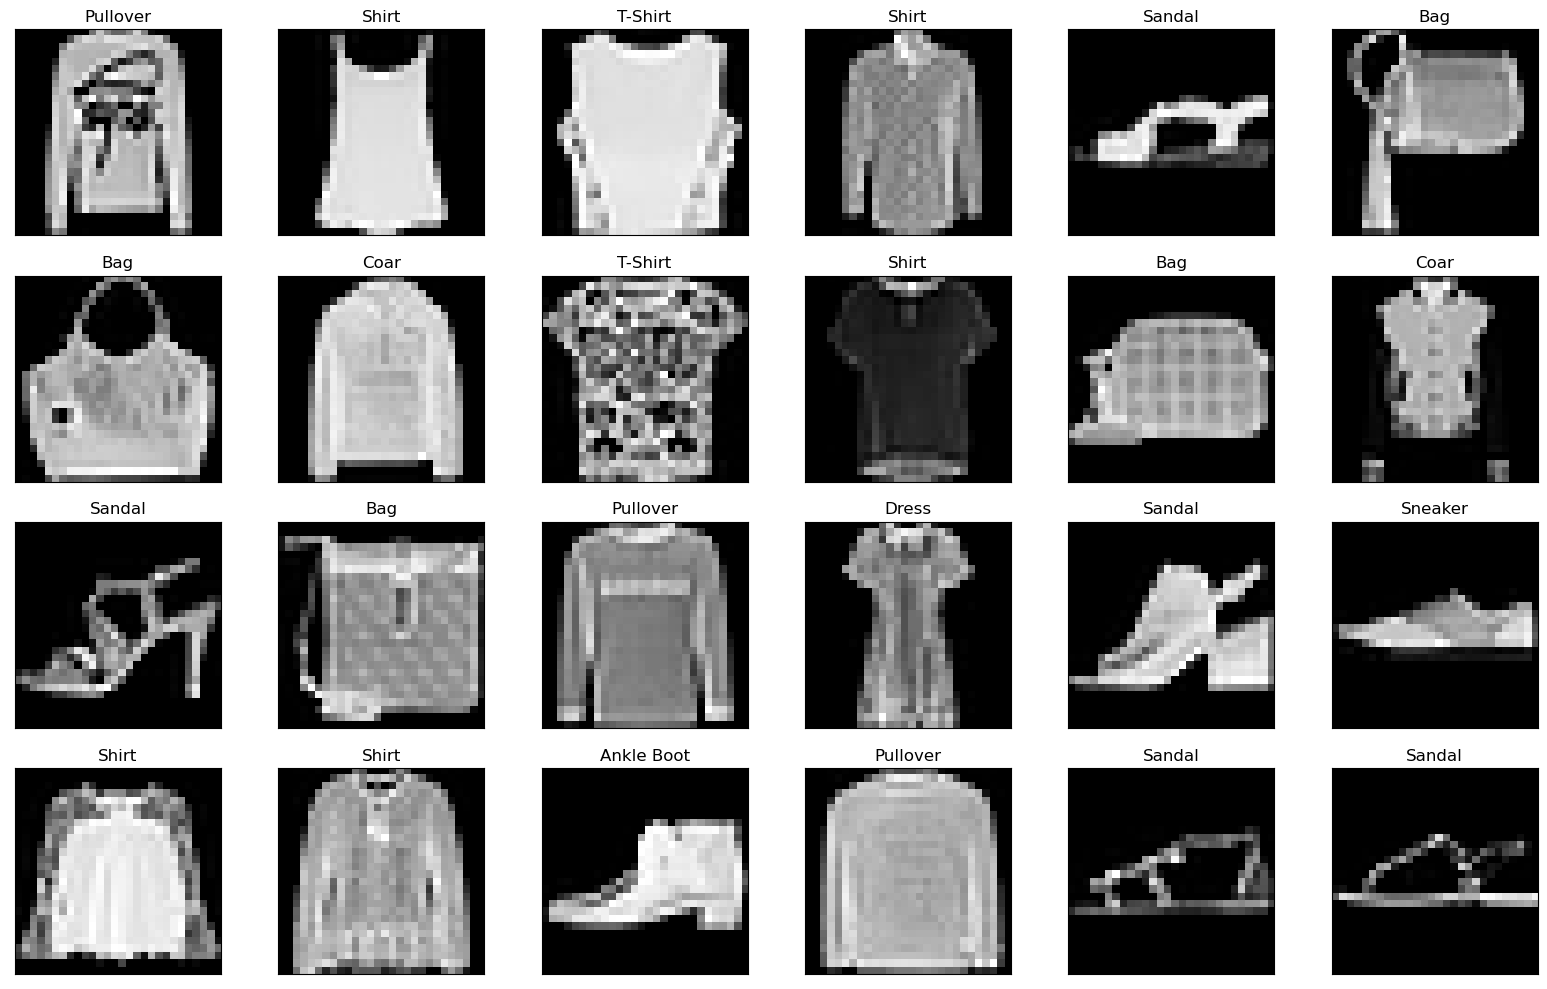

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# train_loader 에서 첫 번째 배치를 가져와 이미지와 라벨을 sample, labels에 저장
samples, labels = next(iter(train_loader))

# 각 클래스의 이름을 숫자와 매칭하여 저장 (총 10개)
classes = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coar',
5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(16, 10)) # 4행 6열의 서브플롯을 생성

for ax, image, label in zip(axs.flatten(), samples, labels):
    image = np.transpose(image.numpy(), (1, 2, 0)) # 차원 변환: (C, H, W) -> (H, W, C)
    
    ax.imshow(image, cmap='gray') # 흑백 이미지로 출력
    ax.set_title(classes[label.item()], fontsize=12) # label.item(): torch.Tensor 타입의 스칼라 값(정수)을 얻기 위해 사용
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

# 6.심층 신경망 모델 생성

In [9]:
class FashionDNN(nn.Module): # 항상 torch.nn.Module을 상속받음
    def __init__(self):
        super(FashionDNN, self).__init__() # FashionDNN 이라는 부모 클래스를 상속받겠다.는 의미
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10) # 10은 클래스 개수를 의미
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# 7.심층 신경망에서 필요한 파라미터 정의

In [10]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 8.심층 신경망을 이용한 모델 학습

In [11]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 100개의 이미지와 레이블이 하나의 배치로 묶여서 가져옴
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train) # 학습 데이터(batch)를 모델에 입력하여 출력값 계산
        loss = criterion(outputs, labels) # 손실값 계산
        optimizer.zero_grad()  # 이전에 계산된 그래디언트 값 초기화
        loss.backward()        # 손실에 대한 그래디언트 계산
        optimizer.step()       # 계산된 그래디언트를 이용하여 가중치 업데이트
        count += 1
        
        if (count % 50)==0: #  매 50번째 iteration마다 test data를 이용해 accuracy를 계산
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                labels_list.append(labels)
                test = Variable(images.view(-1, 1, 28, 28))
                
                outputs = model(test)
                predictions = torch.argmax(outputs, 1).to(device) # 최댓값의 위치
                predictions_list.append(predictions)
                
                correct += (predictions == labels).sum() # 정답을 맞춘 데이터의 수
                total += len(labels) # 총 데이터의 수
        
            accuracy = correct / total * 100 # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
                
        if (count % 500)==0:
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, 
                accuracy))

Iteration: 500, Loss: 0.4169729948043823, Accuracy: 82.20999908447266%
Iteration: 1000, Loss: 0.3395226299762726, Accuracy: 85.00999450683594%
Iteration: 1500, Loss: 0.5943816900253296, Accuracy: 85.41999816894531%
Iteration: 2000, Loss: 0.26271852850914, Accuracy: 85.94999694824219%
Iteration: 2500, Loss: 0.2841881811618805, Accuracy: 86.44000244140625%
Iteration: 3000, Loss: 0.19969618320465088, Accuracy: 86.25%
